# Text binary classification using CNN 

### Import module

In [1]:
# modules
import os
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from utils.embedding import Embeddor
from sklearn.model_selection import train_test_split

plt.style.use("ggplot")
%matplotlib inline

Using TensorFlow backend.


### Load movie reviews data

In [2]:
# loading x and y

src = "./data/rt-polaritydata/"
pos_src = src + "rt-polarity.pos"
neg_src = src + "rt-polarity.neg"

with open(pos_src) as f:
    pos_txt = f.readlines()
    y_pos = [1] * len(pos_txt)

with open(neg_src) as f:
    neg_txt = f.readlines()
    y_neg = [0] * len(neg_txt)
    
x_total = np.concatenate((pos_txt, neg_txt))
y_total = np.concatenate((y_pos, y_neg))
n = np.size(x_total)

print("There is %d elements in x" % n)

There is 10662 elements in x


### Load embeddings

In [3]:
%%time

# parameters
n_emb = 100000
src = "./embeddings"
emb_name = os.listdir(src)[-1]
print("Embedding: %s" % emb_name)
src_emb = os.path.join(src, emb_name)

# embeddor
embeddor = Embeddor(notebook_display=True)
emb_mat = embeddor.load_emb(src_emb, n_emb)
print("Embedding shape: {}".format(emb_mat.shape))

Embedding: fasttext.wiki.en.vec


Widget Javascript not detected.  It may not be installed or enabled properly.



Embedding shape: (100001, 300)
CPU times: user 9.26 s, sys: 653 ms, total: 9.91 s
Wall time: 9.31 s


### CNN hyper-parameters

In [5]:
emb_mat = embeddor.emb
emb_shape = np.shape(emb_mat)
emb_size = emb_shape[1]
x_seq = embeddor.to_seq(x, padding=True)
y_seq = y
seq_size = embeddor.pad_dim
filter_size = 6
num_filters = 100
num_classes = 2

### CNN graph architecture

In [6]:
%%time
# placeholders
x_input = tf.placeholder(tf.int32, shape=[None, None], name='x_input')
y_input = tf.placeholder(tf.int64, shape=[None], name='y_input')
e_input = tf.placeholder(tf.float32, shape=emb_shape, name='e_input')
dropout = tf.placeholder(tf.float32, name="dropout_keep_prob")

with tf.device("/cpu:0"):
    
    with tf.name_scope("embedding"):
        E = tf.Variable(tf.constant(0.0, shape=emb_shape), trainable=False, name="E")
        emb_init = E.assign(e_input)
        emb_seq = tf.nn.embedding_lookup(E, x_input)
        emb_seq_expanded = tf.expand_dims(emb_seq, -1)
    
    with tf.name_scope("convolution"):
        # convolution
        filter_shape = [filter_size, emb_size, 1, num_filters]
        W = tf.Variable(tf.truncated_normal(filter_shape, stddev=0.1), name='W')
        b = tf.Variable(tf.constant(0.1, shape=[num_filters]), name='b')
        conv = tf.nn.conv2d(emb_seq_expanded,
                            W, 
                            strides=[1, 1, 1, 1],
                            padding='VALID',
                            name='conv')
        # non-linearity
        h = tf.nn.tanh(tf.nn.bias_add(conv, b), name='tanh')
        # k-max
        h_pool = tf.nn.max_pool(h,
                                ksize=[1, seq_size - filter_size + 1, 1, 1],
                                strides=[1, 1, 1, 1],
                                padding='VALID',
                                name='pool')
        h_pool_flat = tf.reshape(h_pool, [-1, num_filters])
    
    with tf.name_scope("dropout"):
        h_o = tf.nn.dropout(h_pool_flat, dropout)
        
    with tf.name_scope("output"):
        W_o = tf.Variable(tf.truncated_normal([num_filters, num_classes], stddev=0.1), name='W_o')
        b_o = tf.Variable(tf.constant(0.1, shape=[num_classes]), name='b_o')
        scores = tf.nn.xw_plus_b(h_o, W_o, b_o, name='scores')
        preds = tf.argmax(scores, 1, name='preds')
        
    with tf.name_scope("loss"):
        losses = tf.nn.sparse_softmax_cross_entropy_with_logits(
            logits=scores,
            labels=y_input,
            name='losses')
        loss = tf.reduce_mean(losses, name='loss')

    with tf.name_scope("accuracy"):
        correct_predictions = tf.equal(preds, y_input)
        accuracy = tf.reduce_mean(tf.cast(correct_predictions, 'float'), name='accuracy')
    
    with tf.name_scope("optimization"):
        optimizer = tf.train.AdamOptimizer(1e-3)
        train_op = optimizer.minimize(loss)
        
    init = tf.global_variables_initializer()

CPU times: user 119 ms, sys: 0 ns, total: 119 ms
Wall time: 117 ms


#### Testing specific layer

In [7]:
%%time
with tf.Session() as sess:
    sess.run(init)
    sess.run(emb_init, feed_dict={e_input: emb_mat})
    D = {x_input: x_seq, y_input: y_seq}
    out = sess.run(emb_seq, feed_dict=D)

CPU times: user 270 ms, sys: 261 ms, total: 531 ms
Wall time: 515 ms


### Training CNN

#### Emptying tensorflow summaries

In [8]:
path = "./tensorflow_summaries"
for file in os.listdir(path):
    filepath = os.path.join(path, file)
    if os.path.isfile(filepath) and file != ".gitkeep":
        os.remove(filepath)

#### Parameters

In [9]:
batch_size = 64
num_epochs = 10
p = 0.5
x_train, x_test, y_train, y_test = train_test_split(x_seq, y_seq, train_size=0.75, random_state=0)

#### Training loop

In [10]:
%%time
with tf.Session() as sess:
    # initialization of all variables
    sess.run(init)
    sess.run(emb_init, feed_dict={e_input: emb_mat})
    acc_train = sess.run(accuracy, feed_dict={x_input: x_train, y_input: y_train, dropout: 1})
    acc_test = sess.run(accuracy, feed_dict={x_input: x_test, y_input: y_test, dropout: 1})
    print("init.: _ train acc: %0.2f test acc: %0.2f" %  (acc_train, acc_test))
    
    # perform operation
    losses = []
    for e in range(num_epochs):
        for i in range(x_train.shape[0] // batch_size):
            # idx batches
            idx = i * batch_size
            idxn = min(x_train.shape[0] - 1, (i+1) * batch_size)
            # batches
            batch_xs = x_train[idx: idxn]
            batch_xy = y_train[idx: idxn]
            
            # run train operator
            feed_train = {x_input: batch_xs, y_input: batch_xy, dropout: p}
            __, l = sess.run([train_op, loss], feed_dict=feed_train)
            losses.append(l)

        # for each epoch, run accuracy on train and test
        acc_train = sess.run(accuracy, feed_dict={x_input: x_train, y_input: y_train, dropout: p})
        acc_test = sess.run(accuracy, feed_dict={x_input: x_test, y_input: y_test, dropout: 1})
        print("epoch: %d train acc: %0.2f test acc: %0.2f" %  (e, acc_train, acc_test))
        
    # monitoring
    file_writer = tf.summary.FileWriter('./tensorflow_summaries', sess.graph)

init.: _ train acc: 0.51 test acc: 0.50
epoch: 0 train acc: 0.67 test acc: 0.69
epoch: 1 train acc: 0.74 test acc: 0.74
epoch: 2 train acc: 0.79 test acc: 0.75
epoch: 3 train acc: 0.82 test acc: 0.75
epoch: 4 train acc: 0.85 test acc: 0.76
epoch: 5 train acc: 0.86 test acc: 0.76
epoch: 6 train acc: 0.89 test acc: 0.75
epoch: 7 train acc: 0.92 test acc: 0.76
epoch: 8 train acc: 0.93 test acc: 0.76
epoch: 9 train acc: 0.95 test acc: 0.76
CPU times: user 9min 26s, sys: 1min 23s, total: 10min 49s
Wall time: 1min 3s


#### Training loss

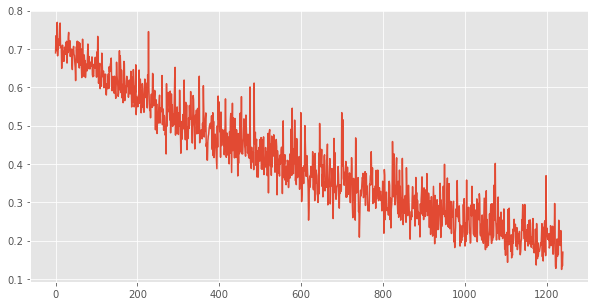

In [11]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(losses)

In [12]:
embeddor.most_similar("france")

[('france', 0.99999976),
 ('franche', 0.65986818),
 ('italy', 0.65398681),
 ('languedoc', 0.64216447),
 ('provence', 0.63572669),
 ('belgium', 0.63431036),
 ('alsace', 0.63328314),
 ('spain', 0.62924433),
 ('french', 0.62637675),
 ('auvergne', 0.62577283)]